In [88]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from msresist.clinical_data import *
from msresist.pre_processing import filter_NaNpeptides, preprocessing
from msresist.clustering import DDMC
import statannot

matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1.5, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

### Import CPTAC Data

In [2]:
phos = filter_NaNpeptides(pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:], tmt=2)
prot = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_Protein.csv").drop_duplicates(subset="geneSymbol").set_index("geneSymbol").select_dtypes(include=float).iloc[:, 4:].reset_index()
rna = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_RNAseq.csv").drop_duplicates(subset="geneSymbol")

_, phosR_tumor, _ = preprocess_phospho(phos)
protR, protR_tumor, _ = preprocess_data(prot)
_, rnaR_tumor, _ = preprocess_data(rna)

pmut = pd.read_csv("/home/marcc/AXLomics/msresist/data/MS/CPTAC/Patient_Mutations.csv")
pmut = pmut[~pmut["Sample.ID"].str.contains("IR")]

/tmp/ipykernel_235781/3777329843.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  prot = pd.read_csv("msresist/data/MS/CPTAC/CPTAC_LUAD_Protein.csv").drop_duplicates(subset="geneSymbol").set_index("geneSymbol").select_dtypes(include=float).iloc[:, 4:].reset_index()


### Import AXL signaling Data

In [3]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)

In [4]:
X.insert(0, "Cluster", ddmc.labels())
c123 = X[(X["Cluster"] == 1) | (X["Cluster"] == 2) | (X["Cluster"] == 3)][["Cluster", "Gene", "Position", "PC9 A", "KO A"]]
c123.head()

,Cluster,Gene,Position,PC9 A,KO A
2,2,TNKS1BP1,Y940-p,0.415388,-0.195927
3,2,PSMC1,Y25-p,-0.108045,-0.476332
4,3,RPS10,Y12-p,0.498325,-0.237557
5,3,RPS10,Y82-p,0.756587,0.126418
7,2,RPS3,Y120-p,0.174842,0.231856


### Questions
1. Is AXL signaling upregulated in AXL high tumors? Can look at RNA, protein, and phosphoprotein level.
2. Does AXL signaling correlate with staging, specific mutations, or the amount of mutations? Is it higher in tumors vs NATs? 

In [106]:
protHL = make_AXL_categorical_data(protR_tumor, protR_tumor, phospho=False, by_samples=True, by_thres=False)

In [107]:
rm = ['SEPT2', 'FYB1', 'CAVIN1', 'KIRREL1', 'CFL1', 'CBLC', 'ICK', 'NME2', 'PSMA2', 'HSPA8', 'GPRC5B', 'ITCH', 'ABL1', 'RBM14', 'PIK3R3', 'SOS1', 'MTOR', 'HGS', 'EPHA5', 'SGMS2', 'SRSF1']
genes = [*set(list(c123["Gene"]))]
for _ in range(5):
    for p in genes:
        if p in rm:
            genes.remove(p)

In [108]:
phl = protHL.reset_index().set_index("geneSymbol").loc[genes]

In [109]:
df_p = phl.reset_index()
p_long = pd.melt(df_p, "geneSymbol", df_p.columns[1:], "Sample", "Log(protein expression)")
p_long.insert(1, "AXL", [s.split("_")[0] for s in p_long["Sample"]])
p_long.insert(2, "Patient ID", [s.split("_")[1] for s in p_long["Sample"]])
p_long.insert(3, "EGFR mutational status", [id_to_egfr[s] for s in p_long["Patient ID"]])

In [117]:
p_long["EGFR mutational status"] = p_long["EGFR mutational status"].replace(0, "EGFR WT")
p_long["EGFR mutational status"] = p_long["EGFR mutational status"].replace(1, "EGFRm")

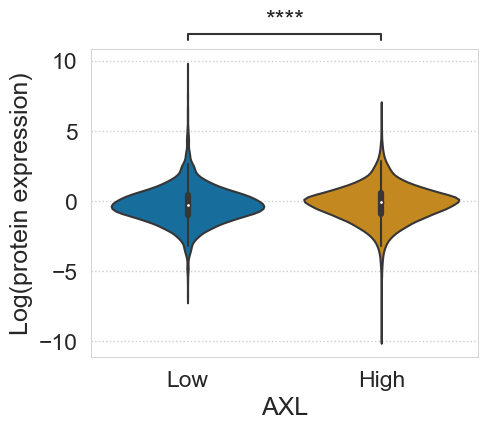

In [127]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(p_long, x="AXL", y="Log(protein expression)", ax=ax, order=["Low", "High"])
statannot.add_stat_annotation(
        ax=ax, 
        data=p_long, 
        x="AXL", 
        y="Log(protein expression)",
        box_pairs=[
                ("Low", "High")
                ], 
        test="Mann-Whitney", 
        text_format="star", 
        loc="outside",
        verbose=False);
plt.savefig("C123_prot_exp.svg")

In [11]:
phosR_tumor = phosR_tumor.reset_index()
phos_long = pd.melt(phosR_tumor, ["Gene", "Position"], phosR_tumor.columns[3:], "Patient ID", "norm p-signal")
pmut = pd.read_csv("/home/marcc/AXLomics/msresist/data/MS/CPTAC/Patient_Mutations.csv")
pmut = pmut[~pmut["Sample.ID"].str.contains("IR")]

id_to_egfr = dict(zip(list(pmut["Sample.ID"]), list(pmut["EGFR.mutation.status"])))
id_to_stage = dict(zip(list(pmut["Sample.ID"]), list(pmut["Stage"])))
phos_long.insert(3, "EGFR mutational status", [id_to_egfr[s] for s in phos_long["Patient ID"]])
phos_long.insert(4, "Stage", [id_to_stage[s] for s in phos_long["Patient ID"]])

axl_by_samples = list(make_AXL_categorical_data(protR_tumor, protR_tumor, phospho=False, by_samples=True, by_thres=False).columns)
id_to_axl = {}
for c in axl_by_samples:
    s = c.split("_")
    id_to_axl[s[1]] = s[0]
phos_long.insert(5, "AXL levels", [id_to_axl[s] if s in id_to_axl.keys() else "High" for s in phos_long["Patient ID"]])

psites = list(zip(list(c123["Gene"]), list(c123["Position"])))
all_ps = list(zip(list(phos_long["Gene"]), list(phos_long["Position"])))
ovp = [ps for ps in psites if ps in all_ps]

In [55]:
df = phos_long.set_index(["Gene", "Position"]).loc[ovp]
df["EGFR mutational status"] = df["EGFR mutational status"].replace(0, "EGFR WT")
df["EGFR mutational status"] = df["EGFR mutational status"].replace(1, "EGFRm")

In [56]:
cdk1 = phos_long[(phos_long["Gene"] == "CDK1") & (phos_long["Position"] == "Y15-p;T14-p")]
cdk1["norm p-signal"] *= -1
df = pd.concat([df.reset_index(), cdk1])
df["EGFR mutational status"] = df["EGFR mutational status"].replace(0, "EGFR WT")
df["EGFR mutational status"] = df["EGFR mutational status"].replace(1, "EGFRm")

/tmp/ipykernel_235781/4272430903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdk1["norm p-signal"] *= -1


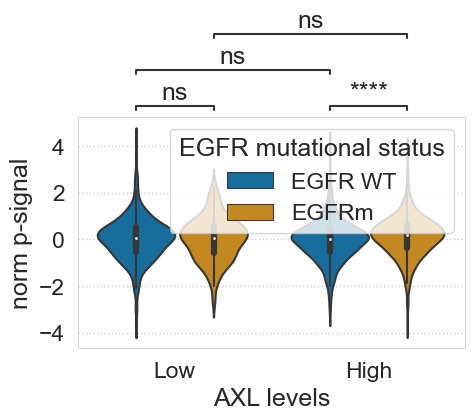

In [91]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.violinplot(df, x="AXL levels", y="norm p-signal", hue="EGFR mutational status", ax=ax)
statannot.add_stat_annotation(
        ax=ax, 
        data=df,
        x="AXL levels", 
        y="norm p-signal",  
        box_pairs=[
                (("Low", "EGFR WT"), ("Low", "EGFRm")),
                (("High", "EGFR WT"), ("High", "EGFRm")),
                (("Low", "EGFR WT"), ("High", "EGFR WT")),
                (("Low", "EGFRm"), ("High", "EGFRm"))
        ],
        hue= "EGFR mutational status",
        test="Mann-Whitney", 
        text_format="star", 
        loc="outside",
        verbose=False);
plt.savefig("C123_phos_AXLlevels_EGFRm.svg")

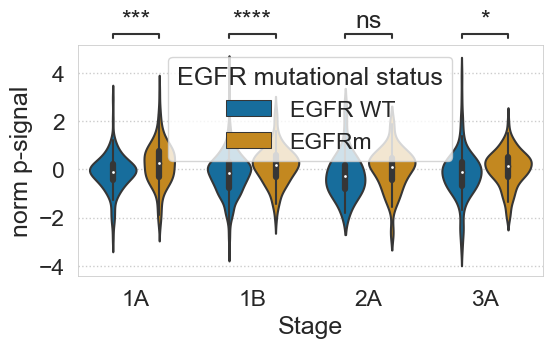

In [128]:
_, ax = plt.subplots(1, 1, figsize=(6, 3))
axl_high = df[(df["AXL levels"] == "High")].set_index("Stage").drop(["1", "3", "2B"]).reset_index()
sns.violinplot(axl_high, x="Stage", y="norm p-signal", hue="EGFR mutational status", ax=ax)
statannot.add_stat_annotation(
        ax=ax, 
        data=axl_high,
        x="Stage", 
        y="norm p-signal",  
        box_pairs=[
                (("1A", "EGFR WT"), ("1A", "EGFRm")),
                (("1B", "EGFR WT"), ("1B", "EGFRm")),
                (("2A", "EGFR WT"), ("2A", "EGFRm")),
                (("3A", "EGFR WT"), ("3A", "EGFRm")),
        ],
        hue= "EGFR mutational status",
        test="Mann-Whitney", 
        text_format="star", 
        loc="outside",
        verbose=False);
plt.savefig("stage.svg")